In [1]:
import mcstasscript as ms
import mcstasscript.jb_interface as ms_widget
import scipp as sc
import plopp as pp
import numpy as np

import matplotlib.pyplot as plt
#%matplotlib widget

import make_SANS_instrument

# SANS exercise


In this notebook you will get this simplified SANS instrument and answer a few questions about the results. You will also get to improve it and run experiments with both with and without a sample.

### Get an instrument object
Here from a function, in future could be online repository

In [2]:
instrument = make_SANS_instrument.make(input_path="run_folder")
nexus_mode = False

## Investigate instrument
First investigate the instrument object *instrument* using some of the available methods. All the methods that help do that start with the word show. In particular, look at what parameters are available and take a look at the instrument geometry.

In [3]:
instrument.show_parameters()

double wavelength         = 6.0  // [AA]  Mean wavelength of neutrons
double d_wavelength       = 3.0  // [AA]  Wavelength spread of neutrons
double n_pulses           = 3.0  // [1] Number of pulses from source
double sample_distance    = 8.0  // [m] Source Sample distance
double enable_sample      = 0    // [1] 0 for nothing, 1 for SANS sample
double SANS_R             = 90   // [AA]  Radius of scattering hard spheres
double detector_distance  = 3.0  // [m] Sample_detector_distance


In [4]:
instrument.show_instrument()

## Set parameters
Before running the instrument we need to set some parameters. The most important one is the *detector_distance* parameter describing the distance between the sample and the detector. Given the need for high angular precision in determining the scattering angle of the neutron, which of these would be best?

- A: 1 m
- B: 2 m
- C: 3 m

Could instead have question on wavelength band to test time of flight knowledge.

In [5]:
# quiz C

Set the parameters of the instrument using the *set_parameters* method.
- sample_distance: 150 m
- wavelength: 6 Å
- wavelength bad: 1.5 Å
- enable_sample: 0
- n_pulses: 1

In [6]:
instrument.set_parameters(sample_distance=150, wavelength=6, d_wavelength=1.5,
                          enable_sample=0, n_pulses=1)

## Run the instrument
Now the simulation can be executed with the backengine method. Store the returned data in a python variable called data.

In [7]:
instrument.settings(ncount=5E6, mpi=6, suppress_output=True)


In [8]:
data = instrument.backengine()
data

[
 McStasData: signal type: 1D  I:22372.7 E:91.8 N:3337010.0,
 
 McStasData: signal_tof type: 2D  I:22372.7 E:91.8 N:3337010.0,
 
 McStasData: signal_tof_all type: 2D  I:22372.7 E:91.8 N:3337010.0,
 
 McStasDataEvent: signal_tof_event with 3337007 events. Variables: p x y n id t,
 
 McStasData: abs_logger_space_zy type: 2D  I:12532200.0 E:18439.7 N:5613590.0]

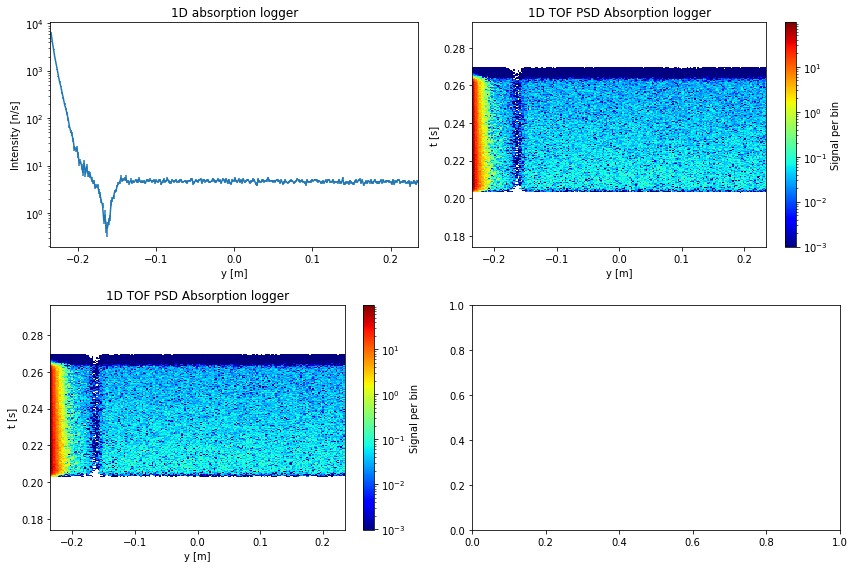

In [9]:
#ms_widget.show(data)
ms.make_sub_plot(data[0:3], figsize=(12, 8), log=True, orders_of_mag=5)

### interpretation of the data
The detector is a He3 tube centered 25 cm above the beam height and with a metal casing. 

What does the signal look like without sample?
- A: Most of the signal close to the direct beam
- B: Flat signal over detector height 
- C: Most of the signal is far away from the direct beam

In [10]:
# quiz A

Is this a problem for a SANS instrument?
- A: Yes
- B: No

In [11]:
# quiz A

How can it be improved?
- A: By adding a Velocity selector
- B: By adding a Chopper
- C: By adding a Beamstop
- D: By adding a Slit

In [12]:
# quiz C

## Improve the instrument
In order to improve the performance of the instrument, we will add a McStas component. The first aspect to consider when doing so is where to place it, both in the component sequence and its physical location. We start by looking at the code sequence.

### McStas sequence 
Use either the *show_diagram* or *show_components* method on the instrument object to get an overview of the component sequence in the instrument. Where would you place the new component?

- A: After the source
- B: Before the sample position
- C: After the sample position
- D: Before the detector position

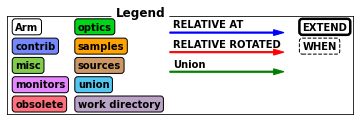

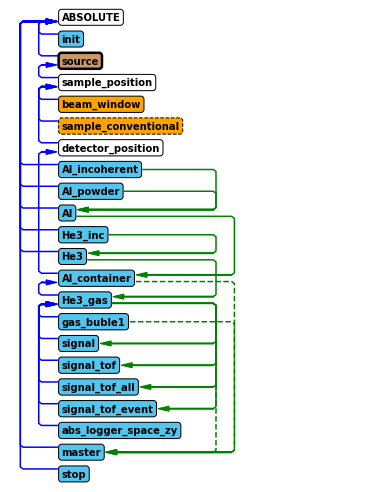

In [13]:
instrument.show_diagram()

In [14]:
# quiz C and D correct

### Which component
Now we need to select what type of component to add to the instrument, here we will need the *Beamstop* component. Use the *component_help* method on the instrument to learn more about this component.

In [15]:
instrument.component_help("Beamstop")

 ___ Help Beamstop __________________________________________________________________
|optional parameter|required parameter|default value|user specified value|
xmin = -0.05 [m] // Lower x bound
xmax = 0.05 [m] // Upper x bound
ymin = -0.05 [m] // Lower y bound
ymax = 0.05 [m] // Upper y bound
xwidth = 0.0 [m] // Width of beamstop (x). Overrides xmin, xmax.
yheight = 0.0 [m] // Height of beamstop (y). Overrides ymin, ymax.
radius = 0.0 [m] // radius of the beam stop in the z=0 plane, centered at Origo
-------------------------------------------------------------------------------------


### Add chopper component and set parameters
Use the *add_component* method on the instrument to add a chopper. Place it in the component sequence by using either the *before* or *after* keyword argument.

Set the parameters:
 - yheight: 0.05 m
 - radius: 0.7 m
 - nslit: 1.0
 - nu, delay and theta_0: To the variables calculated in the instrument (use quotation marks)

In [16]:
beamstop = instrument.add_component("beamstop", "Beamstop", before="detector_position")
beamstop.set_parameters(xwidth=0.1, yheight=0.02)

In [17]:
# quiz(instrument)

### Placing the component in space
The next physical location of the component need to be specified, which is done using the *set_AT* component. This method takes a list of 3 numbers, corresponding to the *x*, *y* and *z* coordinates of the component. One can also specify in what coordinate system one wants to work, which can be that of any preceeding component. Use the *RELATIVE* keyword to work in the *source* coordinate system. The position of the chopper is needed for calculating phase, so it is available as a variable in the instrument, use this variable to set the position.

In [18]:
beamstop.set_AT([0,0,"0.9*detector_distance"], RELATIVE="sample_position")

In [19]:
# quiz(instrument)

### Verify new component
Now that the chopper has been added to the instrument, lets show the component sequence again to verify it was added correctly.

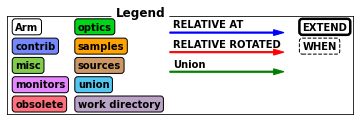

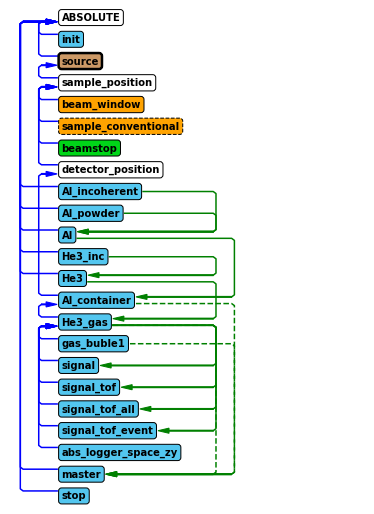

In [20]:
instrument.show_diagram()

## Run improved instrument
Run the improved instrument with the following parameters:
- sample_distance: 150 m
- d_wavelength: 1.5 Å
- enable_sample: 0
- n_pulses: 1

In [28]:
instrument.settings(ncount=5E6, mpi=6, suppress_output=True)

if nexus_mode:
    instrument.set_parameters(sample_distance=150, d_wavelength=1.5, enable_sample=0, n_pulses=3)
    instrument.settings(output_path="SANS_without_sample_NeXus_3_pulse", NeXus=nexus_mode, ncount=1.5E7)
    background_data = instrument.backengine()

In [22]:
instrument.set_parameters(sample_distance=150, d_wavelength=1.5, enable_sample=0, n_pulses=1)
instrument.settings(output_path="SANS_without_sample_NeXus_1_pulse", NeXus=nexus_mode, ncount=5E6)
background_data = instrument.backengine()

In [23]:
background_data

[]

In [24]:
ms.make_sub_plot(background_data[1:3], figsize=(12, 8), log=True, orders_of_mag=5)
#ms_widget.show(data)
#ms.make_sub_plot([improved_data[0], improved_data[3]], figsize=(12, 8), log=True, orders_of_mag=10)

ZeroDivisionError: division by zero

Do you see an improvement compared to earlier results?
- A: Yes
- B: No

In [ ]:
# quiz A

## Run with sample
Now the sample can be added by setting the *enable_sample* parameter to one and calling the *backengine* method again.

In [27]:
if nexus_mode:
    instrument.settings(ncount=1.5E7, mpi=6, suppress_output=True,
                        output_path="SANS_with_sample_NeXus_3_pulse", NeXus=nexus_mode)
    instrument.set_parameters(sample_distance=150, d_wavelength=1.5, enable_sample=1, n_pulses=3)

    sample_data = instrument.backengine()

In [26]:
instrument.settings(ncount=5E6, mpi=6, suppress_output=True,
                    output_path="SANS_with_sample_NeXus_1_pulse", NeXus=nexus_mode)
instrument.set_parameters(sample_distance=150, d_wavelength=1.5, enable_sample=1, n_pulses=1)

sample_data = instrument.backengine()

In [ ]:
ms.make_sub_plot(sample_data[1:3], figsize=(12, 8), log=True, orders_of_mag=10)

Question to check the students are seeing the final dataset.

# Student exercise would end here


### Load data as events and analyze

In [ ]:
import scipp as sc
import numpy as np

def analyze(data):
    
    event = ms.name_search("signal_tof_event", data)
    
    weights = event.get_data_column("p")
    y_values = event.get_data_column("y") + 0.25 # convert to y over direct beam
    t_values = event.get_data_column("t")

    n_events = len(y_values)
    positions = np.array([np.zeros(n_events), y_values, np.zeros(n_events)])

    events = sc.DataArray(
            data=sc.array(dims=['events'], unit=sc.units.counts, values=weights), #, variances=weights),
            coords={
                #'x': sc.array(dims=['events'], unit='m', values=x_values),
                'y': sc.array(dims=['events'], unit='m', values=y_values),
                #'z': sc.array(dims=['events'], unit='m', values=z_values),
                'position' : sc.vectors(dims=['events'], values=positions.T, unit='m'),
                't': sc.array(dims=['events'], unit='s', values=t_values),
            })

    # Would need to convert time to time of flight
    events.coords["t_c"] = events.coords["t"]

    # Set up distances
    detector_distance = event.metadata.parameters["detector_distance"]
    sample_distance = event.metadata.parameters["sample_distance"]
    source_pos = -sample_distance - detector_distance

    # Find distance from sample to each event
    events.coords["sample_y_dist"] = sc.sqrt(events.coords["y"]**2 + sc.scalar(detector_distance, unit="m")**2)

    # Find distance traveled from source to event
    events.coords["source_pixel_distance"] = sc.scalar(sample_distance, unit="m") + events.coords["sample_y_dist"]

    # Calculate speed
    events.coords["speed"] = events.coords["source_pixel_distance"]/events.coords["t"]

    V2K = 0.001588254 # from m/s to Å^-1

    # Convert to wavevector
    events.coords["k"] = events.coords["speed"]*sc.scalar(V2K, unit="Å^-1*s/m")

    # Calculate two theta
    events.coords["two_theta"] = sc.atan(events.coords["y"]/sc.scalar(detector_distance, unit="m"))

    # Calculate Q
    events.coords["Q"] = 2*events.coords["k"]*sc.sin(0.5*events.coords["two_theta"])
    
    return events

In [ ]:
#data = sim_interface.get_data()
events = analyze(sample_data)

### Plot time distribution

In [ ]:
times = events.bin(t=200)
pp.plot(times.hist())

### Plot two theta distributions

In [ ]:
events.bin(two_theta=100).hist().plot(norm="log")

### Plot Q dependence

In [ ]:
events.bin(Q=400).hist().plot(norm="log", vmin=sc.scalar(1E-4, unit="counts"))

### Grab background data

In [ ]:
background_events = analyze(background_data)

### Compare with and without sample

In [ ]:
n_bins = 200
pp.plot({"With sample": events.bin(two_theta=n_bins).hist(),
         "Without sample": background_events.bin(two_theta=n_bins).hist()},
         linestyle={"With sample": "solid", "Without sample": "dashed"},
         norm="log", vmax=5E3, vmin=1E-1)

In [ ]:
n_bins = 200
pp.plot({"With sample": events.bin(Q=n_bins).hist(),
         "Without sample": background_events.bin(Q=n_bins).hist()},
         linestyle={"With sample": "solid", "Without sample": "dashed"},
         norm="log", vmax=5E3, vmin=1E-1)

### Subtract without sample

In [ ]:
n_bins = 160

binned_events = events.bin(Q=n_bins)
q_bins = binned_events.coords["Q"]

pp.plot(binned_events.hist() - background_events.bin(Q=q_bins).hist(),
        norm="log", vmax=1E4, vmin=1E-3)

In [ ]:
instrument.show_parameters()

In [ ]:
import numpy as np

pars = sample_data[0].metadata.parameters

wave_center = pars["wavelength"]
wave_band = pars["d_wavelength"]
wave_min = 8 - 0.5*wave_band
wave_max = 8 + 0.5*wave_band

angle_min = np.arctan(0.02/pars["detector_distance"])
angle_max = np.arctan(0.5/pars["detector_distance"])

q_min = 4*np.pi/wave_max*np.sin(angle_min/2)
q_max = 4*np.pi/wave_min*np.sin(angle_max/2)

print("angle [rad]: ", angle_min, angle_max)
print("q: ", q_min, q_max)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute
def func(q, R):
    return 3 * (np.sin(q * R) - q * R * np.cos(q * R)) / (q * R * q * R * q * R)

# Constants
R = pars["SANS_R"]
num_points = 1000

# Create an array of q values
q = np.linspace(q_min, q_max, num_points)

# Compute the function values
y = func(q, R)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(q, y, label=f'Function for R={R}')
plt.title('Function Plot')
plt.xlabel('q')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
instrument.get_component("He3_gas").show_parameters()

### Compare with theory
$3 * (sin(q*R) - q*R*cos(q*R))/(q*R*q*R*q*R)$

q = np.linspace(q_bins[0].value, q_bins[-1].value, 500)
R = 150
I = 3*(np.sin(q*R) - q*R*np.cos(q*R))/(q**3*R**3)

theory = sc.DataArray(
        data=sc.array(dims=['events'], unit=sc.units.counts, values=weights), #, variances=weights),
        coords={
            #'x': sc.array(dims=['events'], unit='m', values=x_values),
            'y': sc.array(dims=['events'], unit='m', values=y_values),
            #'z': sc.array(dims=['events'], unit='m', values=z_values),
            'position' : sc.vectors(dims=['events'], values=positions.T, unit='m'),
            't': sc.array(dims=['events'], unit='s', values=t_values),
        })

pp.plot({"simulation": binned_events.hist() - background_events.bin(Q=q_bins).hist(),
         "theory": 
        norm="log", vmin=1E-3, vmax=1E3)